<h1><center>Laboratorio 8: Predicciones y Recomendaciones 🔮🪄 </center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Primavera 2024</strong></center>

### **Cuerpo Docente:**

- Profesores: Ignacio Meza, Sebastián Tinoco
- Auxiliar: Eduardo Moya
- Ayudantes: Nicolás Ojeda, Melanie Peña, Valentina Rojas

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Alejandra Toro
- Nombre de alumno 2: Martín Torrico

### **Link de repositorio de GitHub:** [Insertar Repositorio](https://github.com/MartinTorricoP/Laboratorios_MDS7202)

## Temas a tratar
- Series de Tiempo.
- Predicciones vía `Prophet`.
- Implementar un sistema de recomendación utilizando `surprise`.

## Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio
- Comprender qué es una serie de tiempo y su estructura.
- Identificar tendencias, estacionalidades e irregularidades.
- Armar un modelo predictivo para la serie.
- Conocer y aplicar sistemas de recomendación.
- Entender estructura y conocer casos de estudio.


In [461]:
# Librerias globales

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# **1. Forecasting (30 puntos)**


## **Prophet**

Prophet es una herramienta open-source de Facebook utilizada para realizar predicciones en series de tiempo. Esta se basa en la descomposición aditiva, donde tendencias no lineales se ajustan junto a la estacionalidad.

En la ecuación de a continuación se puede ver una idea general de los elementos que construyen a un modelo aditivo como lo es Prophet.

\begin{equation}
y(t) = g(t) + s(t) + h(t) + e(t)
\end{equation}

Donde, $g(t)$ hace referencia a las tendencias, que corresponden a cambios graduales en largos periodos de tiempo. $s(t)$ corresponde a la estacionalidad, son cambios periodicos o cortos en el tiempo. $h(t)$ es el efecto que tienen las festividades sobre las predicciones, mientras que e(t) corresponde al error o ruido. Finalmente $y(t)$, es la predicción hecha por el modelo.

Prophet trabaja por defecto con Piece-Wise Lineal Model, este es un modelo de regresión lineal, en el cual se buscan distintas zonas en que la data presente patrones o tendencias lineales, de estas zonas obtiene su regresión y luego las "une" de manera de representar toda la región, como se puede ver en la ecuación siguiente.

\begin{equation}
y(x)=
    \begin{cases}
        η_1 + \beta_1(x-b_1), & b_1 < x  \leqslant b_2 \\
        η_2 + \beta_2(x-b_2), & b_2 < x  \leqslant b_3 \\
        η_3 + \beta_3(x-b_3), & b_3 < x  \leqslant b_3 \\
        ... \\
        η_k + \beta_{nb}(x-b_{nb-1}), & b_{n-1} < x  \leqslant b_{nb} \\
    \end{cases}
\end{equation}

Siendo $b_1$ el primer punto de quiebre en la serie y así hasta el punto $b_{nb}$ correspondiente al último punto de quiebre de la serie con una cantidad $nb$ de puntos.

Para mayor información de Prophet y como utilizarla, pueden ver su [documentación](https://facebook.github.io/prophet/docs/quick_start.html#python-api), donde hay pueden encontrar un pequeño tutorial de la librería.

## **La Factura de Homero**

<center>
<img src ="https://i.makeagif.com/media/7-30-2018/H_ZAY1.gif" width = 500 />

Homero Simpson ha trabajado en la Planta Nuclear de Springfield por más de 20 años como Inspector de Seguridad, pero recientemente el Sr. Burns le ha permitido trabajar desde casa. Aunque le encanta la flexibilidad que esto le otorga, también ha notado un aumento considerable en su consumo energético en el hogar. Con el uso constante de calefacción en invierno y aire acondicionado en verano, Homero está preocupado por cómo afectará esto a su presupuesto en los próximos meses, ya que planea pasar aún más tiempo en casa.

Afortunadamente, gracias a su puesto en la Planta de Energía Nuclear, Homero tiene acceso a los datos de consumo de energía de cada ciudadano en Springfield, por lo que accede a esta información y almacena el consumo de su hogar en un archivo llamado `energia_homero.csv`. Este archivo posee el consumo diario en el hogar de Homero Simpson desde el Junio del 2016 hasta Julio del 2020.

Con esta valiosa información, Homero espera poder predecir su consumo energético y tomar decisiones informadas para ajustar su presupuesto mensual.

Los datos son los siguientes:

* **date**: Fecha de medición.
* **Energy_kWh**: Consumo diario de energía eléctrica en el hogar de Homero (en kWh).

## 1.1 Series de Tiempo [0 puntos]

### Carga de los datos

En primer lugar, cargue los datos históricos del archivo `energia_homero.csv` al entorno de trabajo. Una vez cargados, asegúrense de transformar la columna `date` a formato `datetime`. Además, visualice el consumo de energía en la casa de Homero mediante la librería `plotly`.


**Respuesta**:

In [462]:
df = pd.read_csv("energia_homero.csv") # leer datos
df['date'] = pd.to_datetime(df['date']) # formatear date como datetime

df.head()

,date,Energy_kWh
0,2016-06-01,29.691
1,2016-06-02,28.789
2,2016-06-03,19.247
3,2016-06-04,22.883
4,2016-06-05,25.195


In [463]:
# Visualización del consumo de energía con plotly
fig = px.scatter(df, x='date', y='Energy_kWh', title='Consumo de energía en la casa de Homero', labels={'date': 'Fecha', 'Energy_kWh': 'Energía (kWh)'})
fig.update_traces(marker=dict(size=3.5))
fig.show()

## 1.2 Controlando la Serie de Tiempo [6 puntos]

<center>
<img src ="https://i.pinimg.com/originals/66/77/88/667788e0b1f08ff1e1cfce11d303b203.gif" width = 500 />

Luego de leer mucho, Homero cree que necesita descomponer la serie de tiempo para poder controlar estos componentes de forma efectiva y lograr que la serie tenga propiedades de una serie estacionaria.

Usted, como buen ciudadano de Springfield, decide ayudar a Homero, el cual le pide que realice lo siguientes pasos:

0. Cree un conjunto de entrenamiento y uno de prueba (a proyectar). Para ello, considere como entrenamiento la información **hasta** el `2020-02-29` y como conjunto de prueba **desde** el `2020-03-01`. [0 puntos]
1. Cree un `Pipeline` que permita obtener una representación de la tendencia de la serie de tiempo, mediante un modelo Lineal. Nombre al pipeline `Pipeline_trend`. [1 punto]
2. Entrene el modelo lineal y luego obtenga predicciones tanto para el conjunto de entrenamiento como para el de prueba (intervalo completo de tiempo). Luego grafique las predicciones y calcule el `Mean Absolute Error` (MAE), tanto para el conjunto de prueba como para el de entrenamiento. [1 punto]
3. Grafique el error (Valor real - Valor predicho) para todo el intervalo de tiempo y responda ¿Hay un comportamiento estacional en la serie? [1 punto]
4.  Cree un `Pipeline` que permita modelar la estacionalidad de la serie temporal mediante términos de Fourier y la represente a través de una Regresión Lineal de la variable objetivo. Nombre a este pipeline `Pipeline_seasonal`. Determine el valor de Periodos `P` y el número de terminos de Fourier `n`. [1 punto]
5. Entrene el nuevo modelo y obtenga predicciones en el intervalo completo de tiempo. Luego grafique y calcule el `MAE` en el conjunto de prueba y en el de entrenamiento. [1 punto]
6. Vuelva a graficar el error y comente los resultados. [1 punto]

**Respuesta**

In [464]:
# 0

df['set'] = np.where(df['date'] >= pd.Timestamp('2020-03-01'), 'Test', 'Train')

train = df[df['set'] == 'Train'].copy()
test = df[df['set'] == 'Test'].copy()

target = 'Energy_kWh'

X_train = train.drop(columns = ['set'])
y_train = train[target].copy()

X_test = test.drop(columns = ['set'])
y_test = test[target].copy()

fig = px.scatter(df, x = df.date, y=target, title='Consumo de energía en la casa de Homero', color = 'set')
fig.update_traces(marker=dict(size=3.5))
fig.show()

In [465]:
# 1

class TimeTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):

        self.init_date = None

    def fit(self, X, y=None):

        assert isinstance(X, pd.DataFrame), 'df must be a pandas DataFrame'
        assert 'date' in X.columns, 'date must be a column of DataFrame'

        self.init_date = X.date.iloc[0]

        return self

    def transform(self, X):

        X = X.copy()

        assert self.init_date is not None, 'transformer must be fitted first!'
        assert isinstance(X, pd.DataFrame), 'df must be a pandas DataFrame'
        assert 'date' in X.columns, 'date must be a column of DataFrame'

        final_date = X.date.iloc[-1] # last date of X

        # generate trend series
        count = (final_date - self.init_date).days + 1
        X['trend'] = [i for i in range(count)][-len(X):]

        return X[['trend']]

    def fit_transform(self, X, y=None):

        X = X.copy()

        assert isinstance(X, pd.DataFrame), 'df must be a pandas Dataframe'
        assert 'date' in X.columns, 'date must be a column of DataFrame'

        self.trend = len(X)
        self.init_date = X.date.iloc[0]

        final_date = X.date.iloc[-1] # last date of X

        # generate trend series
        count = (final_date - self.init_date).days + 1
        X['trend'] = [i for i in range(count)][-len(X):]

        return X[['trend']]

transformer = TimeTransformer()
transformer.fit_transform(X_train) # notar que sólo usa la variable "date"

# Creamos el pipeline_trend para observar la tendencia
Pipeline_trend = Pipeline([
    ('time_features', TimeTransformer()),
    ('ols', LinearRegression())
])

In [466]:
# 2

Pipeline_trend.fit(X_train, y_train)
train_pred = Pipeline_trend.predict(X_train)
test_pred = Pipeline_trend.predict(X_test)

y_pred = np.concatenate([train_pred, test_pred])

fig = px.scatter(df, x=df.date, y=target, title='Consumo de energía en la casa de Homero', color='set')
fig.add_scatter(x=df.date, y=y_pred, mode='lines', name='Prediction', line=dict(color='green', width=2))
fig.update_traces(marker=dict(size=3.5))
fig.show()

mae_train = mean_absolute_error(y_train, train_pred)
mae_test = mean_absolute_error(y_test, test_pred)

print(f'MAE Train: {mae_train:.1f}')
print(f'MAE Test: {mae_test:.1f}')

MAE Train: 10.6
MAE Test: 8.7


In [467]:
#3

# Calcular los errores para el conjunto de entrenamiento y prueba
error_train = y_train - train_pred
error_test = y_test - test_pred

# Concatenar los errores
error = pd.concat([error_train, error_test])

# Graficar los errores
fig = px.line(x=df.date, y=error, title='Error en la predicción', color=df.set)

# Mostrar el gráfico interactivo de errores
fig.show()

Según el gráfico, aparentemente sí existe un comportamiento estacional en la serie.

Podemos notar que anualmente tenemos ciclos de consumo energético que tienen su punto más alto en julio y su punto más bajo en enero (lo cual hace sentido con la estacionalidad, ya que en invierno solemos utilizar más energía que en verano).





In [468]:
#4

class TimeTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, n = 4, p = 365):

        self.init_date = None
        self.n = n
        self.p = p

    def fit(self, X, y=None):

        '''
        Realiza el fit sobre los datos --> guarda la fecha de inicio de entrenamiento.
        '''

        assert isinstance(X, pd.DataFrame), 'df must be a pandas DataFrame'
        assert 'date' in X.columns, 'date must be a column of DataFrame'

        self.init_date = X.date.iloc[0]

    def transform(self, X):

        '''
        Realiza el transform sobre el conjunto X, retornando los términos de fourier.
        '''

        X = X[['date']].copy()

        assert self.init_date is not None, 'transformer must be fitted first!'
        assert isinstance(X, pd.DataFrame), 'df must be a pandas Dataframe'
        assert 'date' in X.columns, 'date must be a column of DataFrame'

        final_date = X.index[-1] # last date of X
        final_date = X.date.iloc[-1] # last date of X

        # generate trend series
        count = (final_date - self.init_date).days + 1
        X['trend'] = [i for i in range(count)][-len(X):]

        # generate fourier terms
        fourier = self.get_fourier_terms(X['trend'], self.n, self.p)

        # concatenate trend + fourier
        X = pd.concat([X, fourier], axis = 1).drop(columns = 'date')

        return X

    def fit_transform(self, X, y=None):

        '''
        implementa el método fit y transform a la vez.
        '''

        X = X[['date']].copy()

        assert isinstance(X, pd.DataFrame), 'df must be a pandas Dataframe'
        assert 'date' in X.columns, 'date must be a column of DataFrame'

        self.trend = len(X)
        self.init_date = X.date.iloc[0]

        final_date = X.date.iloc[-1] # last date of X

        # generate trend series
        count = (final_date - self.init_date).days + 1
        X['trend'] = [i for i in range(count)][-len(X):]

        # generate fourier terms
        fourier = self.get_fourier_terms(X['trend'], self.n, self.p)

        # concatenate trend + fourier
        X = pd.concat([X, fourier], axis = 1).drop(columns = 'date')

        return X

    def get_fourier_terms(self, serie, n, p):

        '''
        Obtiene los términos de fourier de una serie
        '''

        terms = []
        for i in range(1, n + 1):
            sine_term = np.sin(2 * np.pi * i * serie / p)
            cosine_term = np.cos(2 * np.pi * i * serie / p)
            terms.extend([sine_term, cosine_term])

        fourier = np.column_stack(terms)
        fourier = pd.DataFrame(fourier, columns = [f'fourier_{i}' for i in range(n * 2)], index = serie.index) # este paso es opcional

        return fourier

transformer = TimeTransformer(n = 4, p = 365)
transformer.fit_transform(X_train) # notar que sólo usa la variable "date"

# definir Pipeline
Pipeline_seasonal = Pipeline([
    ('time_features', TimeTransformer(n = 2, p = 365)),
    ('ols', LinearRegression())
])


In [469]:
# 5

# Con n = 2 se obtuvo el MAE Test más bajo entre los n testeados (1,2,3,4,5,10).

# entrenar y predecir
Pipeline_seasonal.fit(X_train, y_train)
train_pred = Pipeline_seasonal.predict(X_train)
test_pred = Pipeline_seasonal.predict(X_test)

y_pred = np.concatenate([train_pred, test_pred])

# plot
fig = px.scatter(df, x=df.date, y=target, title='Forecast de Consumo', color='set')
fig.add_scatter(x=df.date, y=y_pred, mode='lines', name='Prediction', line=dict(color='green', width=3))
fig.update_traces(marker=dict(size=3.5))
fig.show()

mae_train = mean_absolute_error(y_train, train_pred)
mae_test = mean_absolute_error(y_test, test_pred)

print(f'MAE Train: {mae_train:.2f}')
print(f'MAE Test: {mae_test:.2f}')

MAE Train: 5.40
MAE Test: 4.44


In [470]:
#6

# calculamos errores de train y test
error_train = y_train - train_pred
error_test = y_test - test_pred
error = pd.concat([error_train, error_test])

# graficamos errores
fig = px.line(x = df.date, y=error, title='Error en la predicción', color = df.set)
fig.show()

Vemos en estos resultados que los errores se han reducido, lo cual se refleja también al comparar los MAE. Esto se nota sobre todo en los datos de entrenamiento, aunque los errores siguen siendo más altos en los datos de prueba.

## 1.3 Un Consejo para Homero [6 puntos]

<center>
<img src ="https://media.tenor.com/sjbvGMLZiDkAAAAM/the-simpsons-homner-simpson.gif" width = 400 />

Homero al observar los resultados obtenidos, se mostró conforme y decidió no seguir averiguando al respecto. Usted, como buen amigo y utilizando sus recientes conocimientos en Forecast, le sugiere a Homero utilizar **Prophet**, una herramienta de modelado de series de tiempo que incluye descomposición de tendencias y estacionalidad, así como la capacidad de incorporar regresores adicionales. Usted le explica a Homero que Prophet es especialmente útil para realizar pronósticos cuando hay patrones estacionales y que podría mejorar los resultados que ha obtenido hasta ahora.

Homero, algo agotado debido al exhaustivo estudio que hizo para entender como funciona esta herramienta, le solicita ayuda para implementar Prophet y evaluar si puede obtener mejores resultados en sus predicciones de consumo energético.

Dado esto, Homero le pide que realice los siguientes pasos:

1. Instale y cargue Prophet a su entorno de trabajo. Luego renombre la variable temporal `date` por `ds` y la variable objetivo `Energy_kWh` por `y`, en los conjuntos de entrenamiento y de prueba. [1 punto]
2. Cree y ajuste el modelo Prophet con sus datos de entrenamiento. Luego realice prepare el dataset de predicciones con su set de prueba y realice las predicciones. `Nota:` Le puede ser útil este [Enlace](https://facebook.github.io/prophet/docs/quick_start.html#python-api) [2 puntos]
3. Grafique las predicciones y las componentes del modelo Prophet. `Nota`: Utilice los métodos `.plot()` y `.plot_components()` de Prophet. [1 punto]
4. Calcule el `MAE` de la predicción en el conjunto de entrenamiento y de prueba. [1 punto]
5. Grafique el error (Valor real - Valor predicho) en todo el intervalo de tiempo. Analice sus resultados y responda: ¿Hay un comportamiento estacional en la serie? [1 punto]

In [471]:
# librerias extras
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

**Respuesta:**

In [472]:
#1

train_prophet = X_train.copy()
train_prophet['ds'] = train_prophet['date']
train_prophet['y'] = y_train
train_prophet = train_prophet[['ds', 'y']]

test_prophet = X_test.copy()
test_prophet['ds'] = test_prophet['date']
test_prophet['y'] = y_test
test_prophet = test_prophet[['ds', 'y']]

In [473]:
#2

m = Prophet()

m.fit(train_prophet)

future = m.make_future_dataframe(periods=129)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1493,2020-07-03,29.916835,21.209401,38.362351
1494,2020-07-04,31.746043,23.630106,41.183873
1495,2020-07-05,32.443075,23.169650,40.956562
1496,2020-07-06,30.518109,21.539632,39.645749
1497,2020-07-07,30.145725,21.890614,38.812682


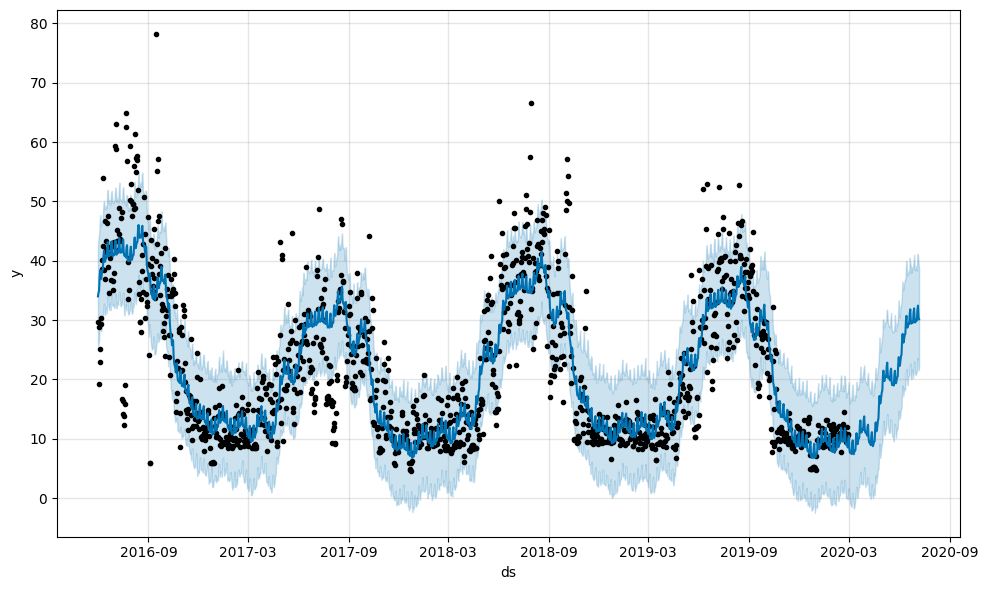

In [474]:
# 3

fig1 = m.plot(forecast)

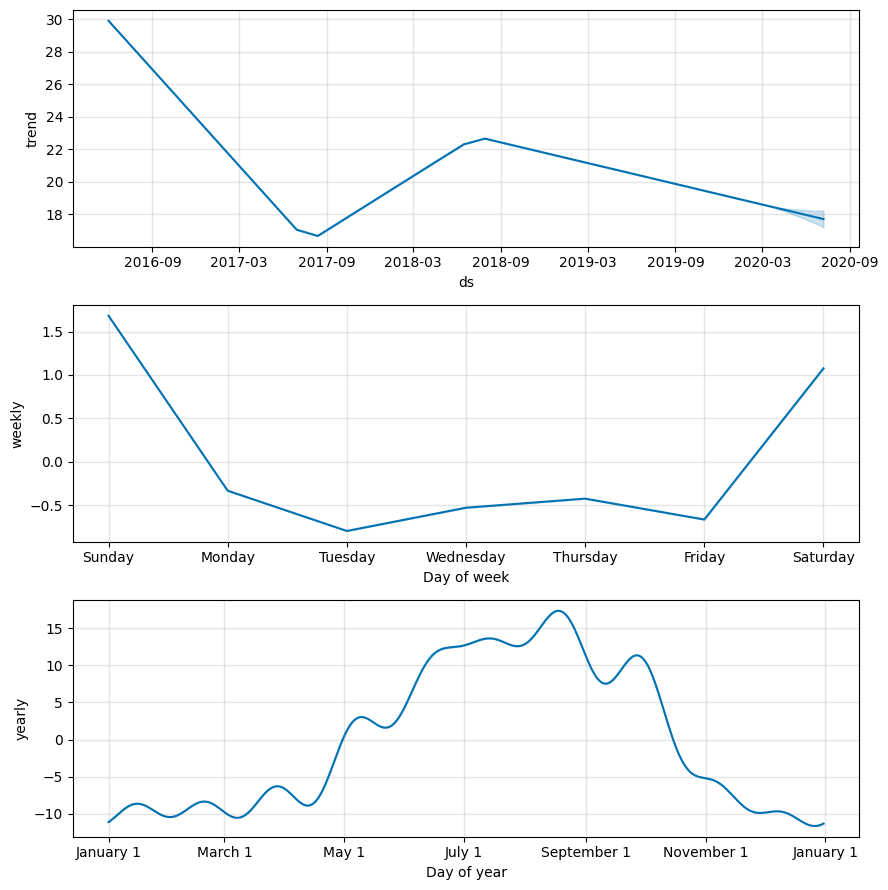

In [475]:
fig2 = m.plot_components(forecast)

In [476]:
#4

forecast_train = forecast.iloc[:-129]  # Todos los días excepto los últimos 129, que son los de testeo
forecast_test = forecast.tail(129) # Días de testeo
mae_train = mean_absolute_error(train_prophet['y'], forecast_train['yhat'])
mae_test = mean_absolute_error(test_prophet['y'], forecast_test['yhat'])
print(f'MAE Train: {mae_train:.2f}')
print(f'MAE Test: {mae_test:.2f}')

MAE Train: 4.82
MAE Test: 4.92


In [477]:
# calculamos errores de train y test
error_train = train_prophet['y'] - forecast_train['yhat']
error_test = test_prophet['y'] - forecast_test['yhat']

error = pd.concat([error_train, error_test])

In [478]:
#5

# graficamos errores
fig = px.line(x=df.date, y=error, title='Error en la predicción - Prophet', color = df.set)
fig.show()

Basándonos en la última figura de los componentes del modelo Prophet, de estacionalidad anual, podemos observar que tenemos otro precedente para afirmar que existe un comportamiento estacional en la serie. En particular, sigue una distribución similar a una normal centrada en el mes de agosto. También, es interesante ver que se observa una estacionalidad a nivel semanal, diferenciando los días de semana a los fin de semana.

Además, similar al apartado anterior, vemos que el error de predicción del modelo también cumple estos patrones estacionales anuales.

## 1.4 Incluyendo Regresores [5 puntos]

<center>
<img src ="https://i.redd.it/64hwjftunjjd1.gif" width = 400 />

Con los nuevos resultados obtenidos del modelo Prophet, usted le aconseja a Homero que puede mejorar sus predicciones al incluir regresores en el modelo, es decir, variables adicionales que pueden influir en la variable objetivo, en este caso, el consumo energético. Homero encuentra que es una buena idea y va en busca de ayuda donde el Profesor Frink, un destacado Científico de Springfield. Para suerte de Homero, Frink tenía un estudio reciente que registra las condiciones climáticas en Springfield, en el mismo intervalo de tiempo en que Homero disponía de los datos de consumo eléctrico. Con esta nueva información, usted le recomienda a Homero que podrían utilizar esta información meteorológica proporcionada como variables exógenas al modelo.

Sin embargo, al no comprender bien la importancia de los regresores, Homero decide confiar en sus capacidades y le pide que, por favor, incluya estas variables en el modelo para evaluar su impacto en las predicciones.

Para ello, usted debe:
0. Seleccionar las variables exógenas a utilizar del archivo `datos_frink.csv`. Añada estas variables a sus conjuntos de entrenamiento y prueba mediante `merge`. [0 puntos]
1. Cree el modelo Prophet e incluya los regresores (variables exógenas) al modelo. Luego realice el entrenamiento. **Hint**: Utilice el método `.add_regressor()`. Mas información en el siguiente [Enlace](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors). [2 puntos]
2. Grafique las predicciones y las componentes del modelo Prophet. `Nota`: Utilice los métodos `.plot()` y `.plot_components()` de Prophet. [1 punto]
3. Calcule el `MAE` de la predicción en el conjunto de entrenamiento y de prueba. Analice sus resultados. [1 punto]
4. Grafique el error (Valor real - Valor predicho) en el conjunto de entrenamiento y de prueba. ¿Hay un comportamiento estacional en la serie? ¿Influyen estas variables en el comportamiento del consumo energético en el hogar de Homero? [1 punto]

Los datos del dataset de Frink son los siguientes:

* **date**: Fecha de medición.
* **Temp_max**: Temperatura máxima registrada durante el día (en °F).
* **Temp_avg**: Temperatura promedio registrada durante el día (en °F).
* **Temp_min**: Temperatura mínima registrada durante el día (en °F).
* **Dew_max**: Punto de rocío máximo registrado durante el día (en °F).
* **Dew_avg**: Punto de rocío promedio registrado durante el día (en °F).
* **Dew_min**: Punto de rocío mínimo registrado durante el día (en °F).
* **Hum_max**: Humedad máxima registrada durante el día (en porcentaje).
* **Hum_avg**: Humedad promedio registrada durante el día (en porcentaje).
* **Hum_min**: Humedad mínima registrada durante el día (en porcentaje).
* **Wind_max**: Velocidad máxima del viento registrada durante el día (en millas por hora, mph).
* **Wind_avg**: Velocidad promedio del viento registrada durante el día (en millas por hora, mph).
* **Wind_min**: Velocidad mínima del viento registrada durante el día (en millas por hora, mph).
* **Press_max**: Presión atmosférica máxima registrada durante el día (en pulgadas de mercurio, Hg).
* **Press_avg**: Presión atmosférica promedio registrada durante el día (en pulgadas de mercurio, Hg).
* **Press_min**: Presión atmosférica mínima registrada durante el día (en pulgadas de mercurio, Hg).

**Respuesta:**

In [479]:
# 0

datos_frink = pd.read_csv('datos_frink.csv')

# date a datetime
datos_frink['date'] = pd.to_datetime(datos_frink['date'])

# Realizamos el merge
train_merged = pd.merge(train_prophet, datos_frink, left_on='ds', right_on='date', how='left')
test_merged = pd.merge(test_prophet, datos_frink, left_on='ds', right_on='date', how='left')

# conservamos las columnas a utilizar
train_merged = train_merged[['ds', 'y', 'Temp_avg', 'Hum_avg', 'Wind_avg']]
test_merged = test_merged[['ds', 'y', 'Temp_avg', 'Hum_avg', 'Wind_avg']]

In [480]:
# 1

# añadimos los regresores
m2 = Prophet()
m2.add_regressor('Temp_avg')
m2.add_regressor('Hum_avg')
m2.add_regressor('Wind_avg')

# entrenamos
m2.fit(train_merged)
future = m2.make_future_dataframe(periods=129)

# merge variables exógenas
future = pd.merge(future, datos_frink[['date', 'Temp_avg', 'Hum_avg', 'Wind_avg']], left_on='ds', right_on='date', how='left')

# predecimos
forecast = m2.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1493,2020-07-03,30.062889,21.251104,38.703844
1494,2020-07-04,31.801569,23.567469,40.421988
1495,2020-07-05,32.867916,24.529318,41.237781
1496,2020-07-06,30.467798,21.754776,39.091488
1497,2020-07-07,29.260051,20.304566,37.937582


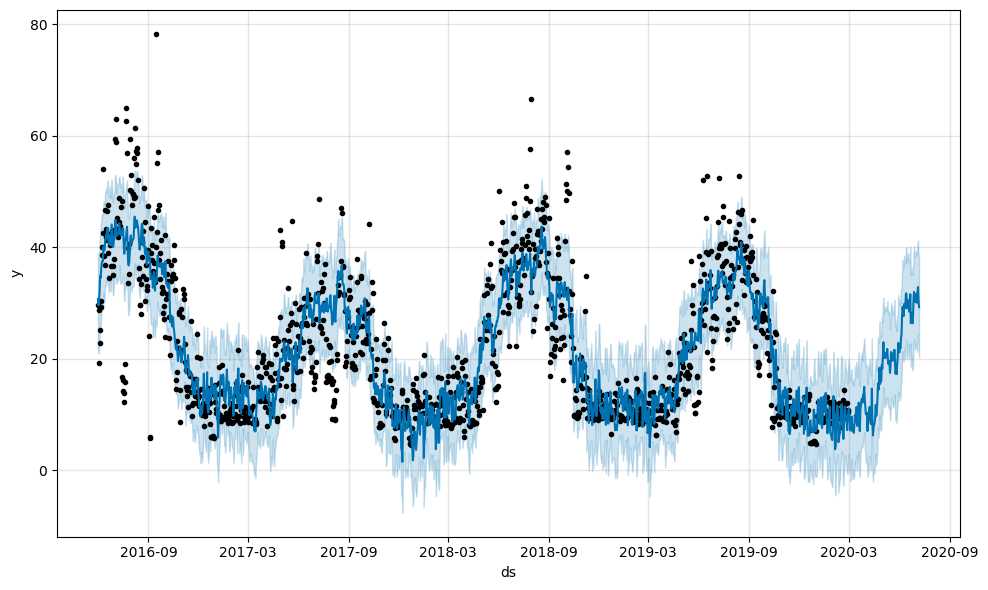

In [481]:
# 2
fig3 = m2.plot(forecast)
fig3.show()

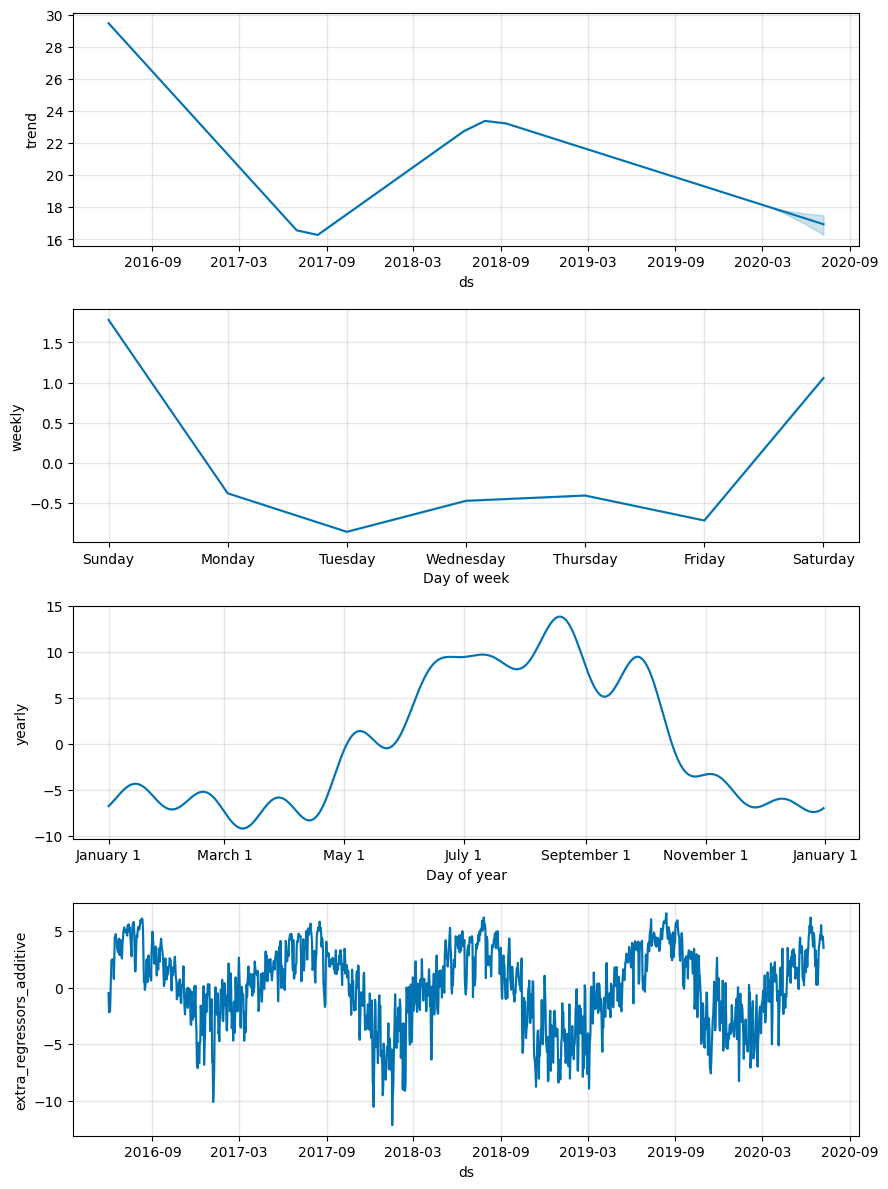

In [482]:
fig4 = m2.plot_components(forecast)
fig4.show()

In [483]:
# 3

forecast_train = forecast.iloc[:-129]  # Todos los días excepto los últimos 129, que son los de testeo
forecast_test = forecast.tail(129) # Días de testeo

mae_train = mean_absolute_error(train_merged['y'], forecast_train['yhat'])
mae_test = mean_absolute_error(test_merged['y'], forecast_test['yhat'])
print(f'MAE Train: {mae_train:.2f}')
print(f'MAE Test: {mae_test:.2f}')

MAE Train: 4.75
MAE Test: 4.58


In [484]:
# calculamos errores de train y test
error_train = train_merged['y'] - forecast_train['yhat']
error_test = test_merged['y'] - forecast_test['yhat'].reset_index(drop=True)
error = pd.concat([error_train, error_test]).reset_index(drop=True)

In [485]:
# graficamos errores
fig = px.line(x = df.date, y=error, title='Error en la predicción - Regresores', color=df.set)
fig.show()

Sí, nuevamente podemos encontrar un comportamiento estacional en la serie.

En esta ocasión basándonos en la última figura de los componentes del modelo Prophet, asociado a los regresores, nuevamente podemos observar (aquí más claramente) un comportamiento estacional en la serie.

Podemos agregar a partir de la reducción de los valores del MAE, que estos factores sí ayudan a predecir el comportamiento del consumo energético en el hogar de Homero.

## 1.5 Aplicando Lags [7 puntos]

<center>
<img src ="https://i.gifer.com/J45h.gif" width = 400 />

Homero, satisfecho con los resultados obtenidos, cree que aún puede mejorar el rendimiento del modelo incorporando lags de las variables exógenas. Se le ocurre que, al incluir estos lags, podría identificar cómo los valores pasados de las variables influyen en la evolución de la variable objetivo. Con esta idea en mente, Homero solicita su ayuda para encontrar y aplicar los lags adecuados a las variables exógenas de manera efectiva.

Para ello, a usted se le pide que:

1. Calcule la `Autocorrelación Parcial` de las variables exógenas `avg` que usted haya considerado. Por ejemplo: `Temp_avg, Dew_avg, etc`. Luego determine la cantidad de rezagos (lags) que se va a aplicar a cada una de las variables. Justifique. [1 punto]

2. Aplique los lags determinados en el paso anterior e incluyalos como variables en los conjuntos train y test. [1 punto]

3. Impute los valores nulos de los nuevos atributos lags mediante la media de cada variable. [1 punto]

4. Cree y entrene el modelo Prophet e incluya las variables exógenas y adicionalmente sus respectivos lags al modelo. [1 punto]

5. Grafique las predicciones y las componentes del modelo Prophet. `Nota`: Utilice los métodos `.plot()` y `.plot_components()` de Prophet. [1 punto]
6. Calcule el `MAE` de la predicción en el conjunto de prueba y en el de entrenamiento. Analice sus resultados. [1 punto]
7. Grafique el error (Valor real - Valor predicho) en el conjunto de entrenamiento y en el de prueba. ¿Hay un comportamiento estacional en la serie? ¿Como afecta la inclusión de los lags en el desempeño del modelo? [1 punto]


**Respuesta:**

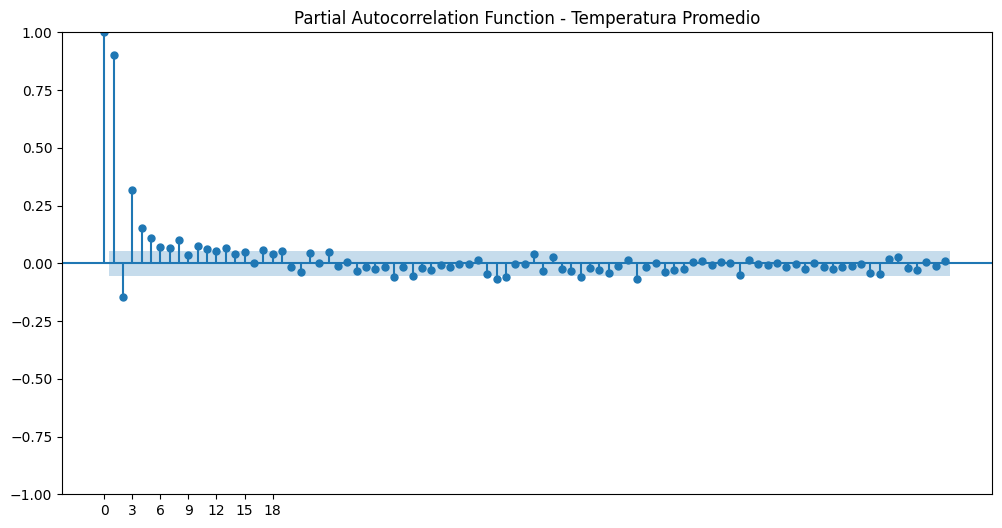

In [486]:
# 1

fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(train_merged['Temp_avg'], lags=90, alpha = 0.05, ax = ax) # 5% de significancia
plt.title('Partial Autocorrelation Function - Temperatura Promedio')
ax.set_xticks(range(0, 21, 3))
plt.show()

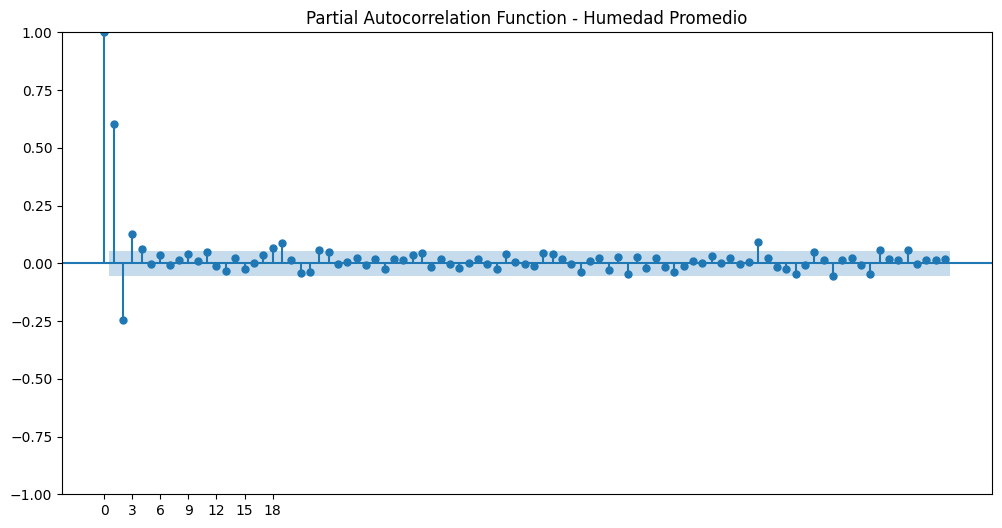

In [487]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(train_merged['Hum_avg'], lags=90, alpha = 0.05, ax = ax) # 5% de significancia
plt.title('Partial Autocorrelation Function - Humedad Promedio')
ax.set_xticks(range(0, 21, 3))
plt.show()

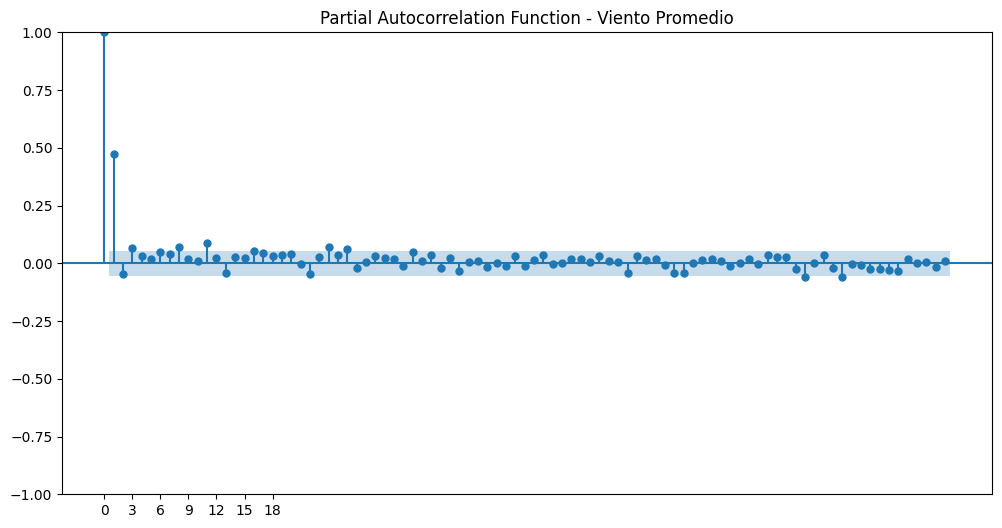

In [488]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(train_merged['Wind_avg'], lags=90, alpha = 0.05, ax = ax) # 5% de significancia
plt.title('Partial Autocorrelation Function - Viento Promedio')
ax.set_xticks(range(0, 21, 3))
plt.show()

Se aplicará rezagos de 1 en las 3 variables. Esto es porque sólo el primer rezago cuenta con valores significativos según los gráficos anteriores.

In [489]:
#2

# Función para generar los lags
class LagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lag=1, window=3):
        self.lag = lag
        self.window = window

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = pd.DataFrame(index=X.index)
        for col in X.columns:
            X_transformed[f'{col}_lag_{self.lag}'] = X[col].shift(self.lag)
            X_transformed[f'{col}_rolling_{self.window}'] = X[col].rolling(self.window).mean()
        return X_transformed

# Lags e imputación sobre las columnas exógenas
lag_pipeline = Pipeline([
    ('lagger', LagTransformer(lag=1, window=3)),  # Generar lags y medias móviles
    ('imputer', SimpleImputer(strategy='mean'))    # Imputar valores nulos
])

In [490]:
# 3

# Aplicar el pipeline de lags a las columnas específicas
col_transformer = ColumnTransformer([
    ('lags', lag_pipeline, ['Temp_avg', 'Hum_avg', 'Wind_avg'])
])

# Pipeline de lags al conjunto de entrenamiento
X_train_lagged = col_transformer.fit_transform(train_merged[['Temp_avg', 'Hum_avg', 'Wind_avg']])

# Juntamos variables exógenas con los lags respectivos
X_train_lagged_df = pd.DataFrame(X_train_lagged, columns= ['Temp_avg_lag_1', 'Temp_avg_rolling_3', 'Hum_avg_lag_1', 'Hum_avg_rolling_3',
                  'Wind_avg_lag_1', 'Wind_avg_rolling_3'], index=train_merged.index)

# Unimos variables lag al conjunto de entrenamiento
train_merged_lagged = pd.concat([train_merged, X_train_lagged_df], axis=1)

# Variables exógenas y sus lags con modelo Prophet
m3 = Prophet()
m3.add_regressor('Temp_avg')
m3.add_regressor('Hum_avg')
m3.add_regressor('Wind_avg')
m3.add_regressor('Temp_avg_lag_1')
m3.add_regressor('Temp_avg_rolling_3')
m3.add_regressor('Hum_avg_lag_1')
m3.add_regressor('Hum_avg_rolling_3')
m3.add_regressor('Wind_avg_lag_1')
m3.add_regressor('Wind_avg_rolling_3')


In [491]:
# 4

# Entrenar el modelo
m3.fit(train_merged_lagged)

# Aplicar el pipeline de lags al conjunto de test
X_test_lagged = col_transformer.transform(test_merged[['Temp_avg', 'Hum_avg', 'Wind_avg']])

# Convertir el resultado a DataFrame para hacer el merge con el test set
X_test_lagged_df = pd.DataFrame(X_test_lagged, columns=lagged_columns, index=test_merged.index)

# Añadir las variables lagged al conjunto de test
test_merged_lagged = pd.concat([test_merged, X_test_lagged_df], axis=1)

# Concatenar el conjunto de entrenamiento con el conjunto de test
merged_lagged = pd.concat([train_merged_lagged, test_merged_lagged], axis=0)

# Verificar el tamaño del nuevo DataFrame
merged_lagged.reset_index(drop=True, inplace=True)

merged_lagged_predict = merged_lagged.drop(columns=['y'])

# Predecir
forecast = m3.predict(merged_lagged_predict)

# Mostrar las últimas predicciones
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1493,2020-07-03,30.573901,21.549121,39.210653
1494,2020-07-04,32.149186,23.633861,40.950648
1495,2020-07-05,32.912471,24.415065,41.248109
1496,2020-07-06,30.858818,22.005778,39.180024
1497,2020-07-07,29.649265,21.625945,37.801949


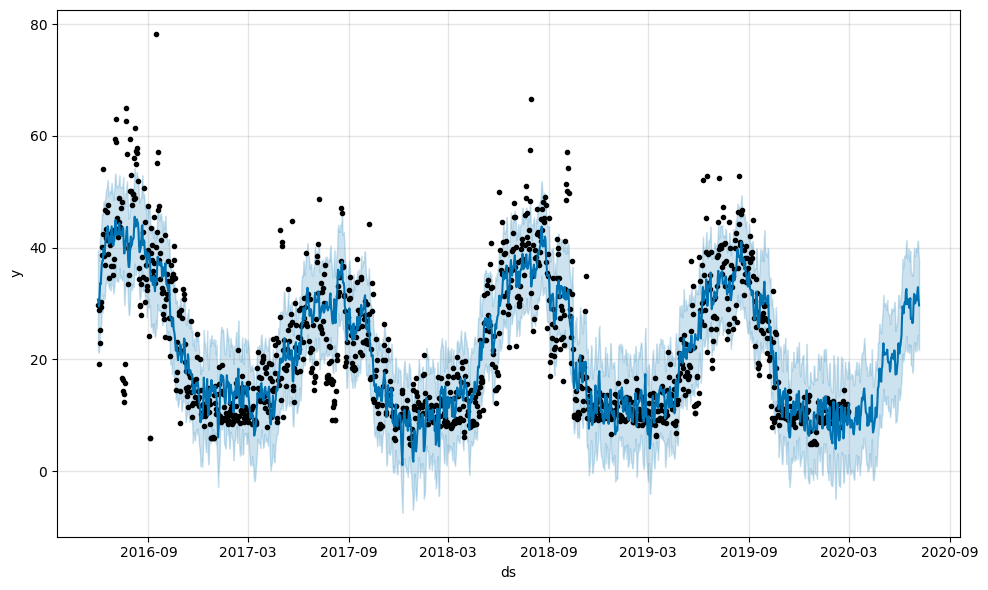

In [492]:
#5

fig5 = m3.plot(forecast)
fig5.show()

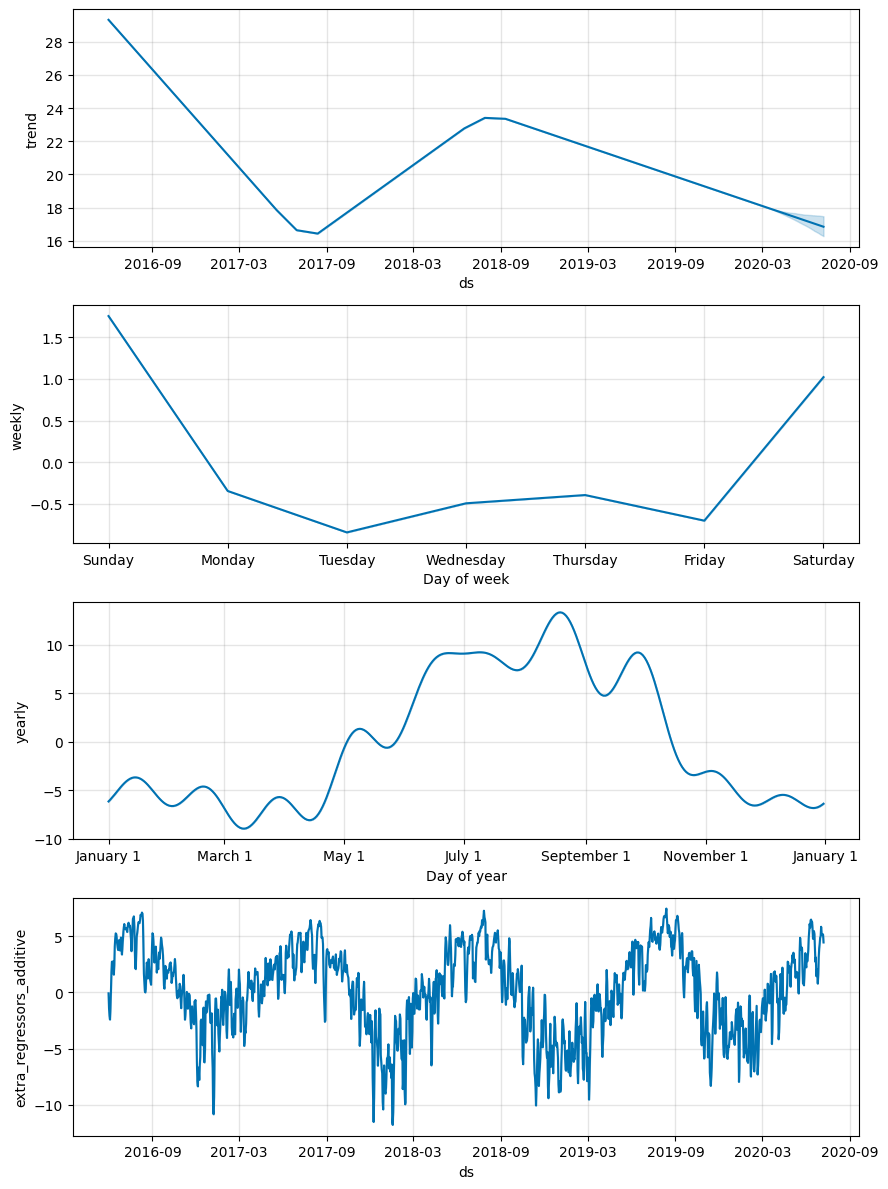

In [493]:
fig6 = m3.plot_components(forecast)
fig6.show()

In [494]:
# 6

forecast_train = forecast.iloc[:-129]  # Todos los días excepto los últimos 129, que son los de testeo
forecast_test = forecast.tail(129) # Días de testeo

mae_train = mean_absolute_error(train_merged_lagged['y'], forecast_train['yhat'])
mae_test = mean_absolute_error(test_merged_lagged['y'], forecast_test['yhat'])
print(f'MAE Train: {mae_train:.2f}')
print(f'MAE Test: {mae_test:.2f}')

MAE Train: 4.73
MAE Test: 4.52


Notamos que el MAE tanto de entrenamiento como de testeo disminuye. Sin embargo no se muestra una diferencia significativa con el resultado anterior.

In [495]:
#7

# calculamos errores de train y test
error_train = train_merged_lagged['y'] - forecast_train['yhat']
error_test = test_merged_lagged['y'] - forecast_test['yhat'].reset_index(drop=True)
error = pd.concat([error_train, error_test]).reset_index(drop=True)

# graficamos errores
fig = px.line(x = df.date, y=error, title='Error en la predicción - Lags', color=df.set)
fig.show()

Nuevamente sí, vemos un comportamiento estacional en la serie.

La inclusión de los lags, como se ve con el errores medios, afecta positivamente en el desempeño delo modelo ya que se reducen estos errores, sin embargo, no de manera muy significativa.

## 1.6 Optimizando Prophet [6 puntos]

<center>
<img src ="https://i.gifer.com/BKlg.gif" width = 500 />

Homero, contento con sus resultados, decide compartir su trabajo en LinkedIn. Sin embargo, justo antes de realizar la publicación, su hija Lisa Simpson le comenta que su modelo podría mejorar aún más mediante la optimización de hiperparámetros. Aunque Homero no entiende muy bien a qué se refiere Lisa, decide confiar en su conocimiento y le pide ayuda para implementar la optimización.

Lisa le prepara una función llamada optimize_prophet, que recibe como entrada el registro histórico, los datos a predecir (futuros), el nombre de las variables exógenas y una grilla de hiperparámetros que se desea modificar.

Después de varios intentos, Homero no logra utilizar la función de Lisa y, desesperado por publicar sus resultados en internet, se acerca a usted en busca de ayuda.

Para ello, usted decide realizar los siguientes pasos:

1. Crear una grilla donde se modifiquen los siguientes hiperparámetros: `changepoint_prior_scale`, `seasonality_prior_scale`, `seasonality_mode`, `changepoint_range` y encuentre los hiperparámetros que optimicen el `MAE`. `Nota:` Utilice la función `optimize_prophet()` dada en el enunciado. [1 punto]
2. Crear y entrenar un modelo Prophet utilizando los mejores parámetros encontrados, incluyendo regresores (variables exógenas). [2 puntos]
3. Grafique las predicciones y las componentes del modelo Prophet. `Nota`: Utilice los métodos `.plot()` y `.plot_components()` de Prophet. [1 punto]
4. Calcule el `MAE` de la predicción en el conjunto de entrenamiento y en el de prueba. [1 punto]
5. Grafique el error (Valor real - Valor predicho) en ambos conjuntos. Analice sus resultados. [1 punto]


In [496]:
#NO MODIFICAR ESTA CELDA

import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import logging

# Silenciar el logging de Prophet
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)


def optimize_prophet(df, df_to_pred, features, param_grid ):
  '''
  Función que recibe como entrada:
  -df: data entrenamiento.
  -df_to_pred: data a predecir (test).
  -features: lista de variables exógenas.
  -param_grid: grilla de hiperparámetros.

  Retorna:
  -tuning_results: Dataframe con resultados de la optimización.
  -best_params: Diccionario de mejores parámetros encontrados.
  '''

  # Generate all combinations of parameters
  all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
  MAEs = []  # Store the MAEs for each params here

  # Use tqdm to add a progress bar to the parameter tuning loop
  for params in tqdm(all_params, desc="Tuning Prophet parameters"):
      m = Prophet(**params)  # Fit model with given params
      for feature in features:
          m.add_regressor(feature)
      m.fit(df)

      # Prepare future dataframe
      df_prop = m.make_future_dataframe(periods=len(df_to_pred))
      df_feat = pd.concat([df[features], df_to_pred[features]]).reset_index(drop=True)
      df_prop[features] = df_feat[features]

      # Make predictions
      forecast = m.predict(df_prop)
      forecast_pred = forecast[forecast['ds'].isin(df_to_pred['ds'])].reset_index(drop=True)

      # Calculate MAE for the predictions
      mae_pred = mean_absolute_error(df_to_pred['y'], forecast_pred['yhat'])
      MAEs.append(mae_pred)

  # Find the best parameters
  tuning_results = pd.DataFrame(all_params)
  tuning_results['MAEs'] = MAEs
  tuning_results = tuning_results.sort_values(by='MAEs', ascending=True)
  best_params = all_params[np.argmin(MAEs)]
  return tuning_results, best_params

**Respuesta:**

In [497]:
#CODIGO AQUI

# **2. Sistemas de Recomendación (30 puntos)**

## Homero contra la Prohibición

<center>
<img src ="https://i.ytimg.com/vi/rMSXXuhZjYY/maxresdefault.jpg" width = 500 />

En Springfield, el caos estalló cuando las autoridades prohibieron el alcohol. Pero como siempre, donde otros ven problemas, Homero Simpson ve oportunidades. Decidido a mantener las fiestas vivas, se convirtió en el Barón de la Cerveza en un abrir y cerrar de ojos. Con la ayuda de su buen amigo Moe el cantinero, Homero obtuvo un valioso dataset llamado `cervezas.csv`, que contiene valoraciones de los ciudadanos de Springfield sobre distintas cervezas. Homero quiere asegurarse de ofrecer las cervezas más apreciadas para mantener a su clientela oculta y feliz, mientras eludía la mirada del estricto Elio Pez. Por ende, Homero lo contacta para solicitar de su ayuda en esta nueva labor.

El dataset contiene los siguientes atributos:

  * userId: Identificador de los ciudadanos/usuarios
  * beerId: Identificador único de cada cerveza
  * rating: Evaluación otorgada por el ciudadano a la cerveza, en un rango de 1.0 a 5.0.
  * beerName: Nombre de la cerveza
  * beerStyle: Tipo de Cerveza.



In [498]:
!pip install surprise

In [499]:
# Librerias extras
from sklearn.preprocessing import LabelEncoder

from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.accuracy import mae
from surprise import NMF
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
from copy import deepcopy

## Carga de los datos [0 puntos]

Cargue el dataset `cervezas.csv` y realice una breve exploración de los datos. ¿Hay valores nulos? ¿Cuantos cervezas se estan evaluando? ¿Cuantos ciudadanos participaron de esta evaluación?

In [500]:
#CODIGO AQUI

## 2.1 Caracterización Inicial [3 puntos]

Antes de entrenar nuestro sistema recomendador, es necesario caracterizar los datos disponibles y de esta manera tener un mejor entendimiento del problema a resolver. Para esto, se le pide lo siguiente:

1. Genere gráficos y/o estadística descriptiva con los datos. Utilice su análisis para responder las siguientes preguntas: [2 puntos]
  - ¿Cuantos *usuarios* hay en los datos?
  - ¿Cuantos *productos* hay en los datos?
  - ¿Cuantas *calificaciones* hay en los datos?
  - ¿Cuantas *calificaciones* faltantes hay en los datos?
  - ¿Cual es la media de las *calificaciones* entregadas por los usuarios? ¿Cómo cambia esto a través de los productos?  
2. Transforme los datos entregados a una matriz (usuario, producto) y muestre sus resultados. [1 punto]

In [501]:
#

## 2.2 Método Basado en Contenido [4 puntos]

<center>
<img src ="https://is1-ssl.mzstatic.com/image/thumb/WfNa_TwFpJoTWXQmU-BrbA/1200x675.jpg" width = 500 />

Como primera tarea, Homero le pide centrarse en las características de las cervezas y no en la interacción de los ciudadanos con esta. Adicionalmente, Homero esta buscando nuevas cervezas para su consumo personal, donde usted pudo notar que Homero esta identificado como `userId = 100` en el dataset. Por ende, Homero le pide las siguientes acciones:

1. Cree un dataframe que contenga las características de las cervezas, excluyendo las evaluaciones de los ciudadanos. `Nota:` No considere valores duplicados. [1 punto]
2. Implemente el método Bag of Words para procesar la columna `beerStyle`. Para ello, transforme las palabras a minúsculas, elimine stopwords en inglés y filtre las palabras que aparezcan en 10 documentos como mínimo. Guarde su resultado como un DataFrame. [1 punto].
> `Nota:` Le puede ser útil esta [documentacion](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) y el método `.get_feature_names_out()`.
3. Cree una función que imprima las top 5 cervezas similares a `Chocolate Porter`, utilizando como medida de similitud la similitud coseno. [1 punto]
4. Identifique la cerveza mejor evaluada por Homero (`userId = 100`) y obtenga las top 5 cervezas similares a esa cerveza. [1 punto]

**Respuesta:**

In [502]:
#CODIGO AQUI


## 2.3 Filtros Colaborativos [16 puntos]

<center>
<img src ="https://i.makeagif.com/media/2-08-2016/McmGFQ.gif" width = 400 />

Después de consolidarse como el Barón de la Cerveza en Springfield, Homero Simpson decidió llevar su negocio clandestino a otro nivel. Al ser el único proveedor de alcohol en la ciudad, quiere asegurarse de que cada cerveza que elabora sea de la mejor calidad posible. Para lograrlo, planea usar las evaluaciones pasadas que los ciudadanos de Springfield han registrado sobre las distintas cervezas. Inspirado por los consejos de su amigo Moe, Homero se enteró de que puede implementar un sistema de recomendación basado en filtros colaborativos.

Ahora, Homero necesita de su ayuda para diseñar y elaborar distintos sistemas de filtros colaborativos que le permitan continuar con su reinado cervecero.

### 2.3.1 Filtros Colaborativos Basados en Memoria [8 puntos]

Para este tipo de filtros, Homero le pide lo siguiente:

1. Transforme el DataFrame de `pandas` a Dataset de `surprise`. `Hint`: Utilice solamente los identificadores de ciudadano, cerveza y rating. ¿Importa el orden? [1 punto]
2. Genere un conjunto de entrenamiento y uno de prueba, asegurando que el 30% de los datos sea destinado al conjunto de prueba. No olvide fijar una semilla para garantizar reproducibilidad. [1 punto]
3. Entrene un modelo de **KNN basado en usuarios** utilizando la `similitud coseno`. Luego realice predicciones en el conjunto de prueba. `Nota`: Le puede ser útil la siguiente [documentación](https://surprise.readthedocs.io/en/stable/knn_inspired.html) [2 puntos]
4. Calcule el MAE (Mean Absolute Error) de las predicciones realizadas por el modelo y muestre las predicciones en un DataFrame para su análisis. `Nota:` Le puede ser útil la siguiente [documentación](https://surprise.readthedocs.io/en/stable/accuracy.html#surprise.accuracy.mae) [2 puntos]
5. Repita los pasos 3 y 4 pero utilizando un modelo de **KNN basado en los productos**. [2 puntos]

**Respuesta:**

In [503]:
#CODIGO AQUI

### 2.3.2 Filtros Colaborativos Basados en Modelo [8 puntos]

Ahora Homero le pide que cambie el enfoque del tipo de filtro colaborativo a uno basado en modelo. Por ende, Homero le pide lo siguiente:

1. Entrene un modelo `NMF` , asegurándose de fijar la semilla para reproducibilidad. Luego genere predicciones para el conjunto de prueba. [2 puntos]
2. Calcule el MAE de las predicciones obtenidas y muestre los resultados de las predicciones en un DataFrame para su analisis. [1 punto]
3. Entrene un modelo `SVD` sobre el conjunto de entrenamiento. Posteriormente, genere las predicciones para el conjunto de prueba. [2 puntos]
4. Calcule el MAE de las predicciones y muestre los resultados de las predicciones en un DataFrame. [1 punto]
5. Compare los resultados de ambos modelos y seleccione el mejor a su criterio. Justifique. [2 puntos]

**Respuesta**

In [504]:
#CODIGO AQUI

## 2.4 El Mejor Filtro Colaborativo [7 puntos]

<center>
<img src ="https://media.giphy.com/media/citBl9yPwnUOs/giphy.gif" width = 400 />

Homero Simpson desea perfeccionar y extender su sistema de recomendaciones para cervezas en Springfield. En esta fase, busca implementar técnicas que le permitan no solo predecir las preferencias de los ciudadanos, sino también evaluar métricas que midan la eficacia de sus recomendaciones. Con el objetivo de recomendar las mejores K cervezas para usuarios específicos, Homero buscará comprender mejor cómo optimizar su sistema y satisfacer a sus clientes.

Para ello, usted ayudará a Homero realizando las siguientes labores:

1. Implemente la función `get_top_n()` que le permita extraer las `N` mejores cervezas recomendadas para cada ciudadano utilizando las predicciones generadas por el mejor modelo seleccionado en la sección anterior. Luego obtenga las `3` mejores cervezas recomendadas para Homero (`userId = 100`). `Hint`: Para cada ciudadano, elimine las predicciones duplicadas. [2 puntos]
2. Realice predicciones de rating para 5 cervezas aleatorias no evaluadas por Homero, para estimar las calificaciones que Homero podría darles. [1 punto]
3. Calcule los promedios de `precisión@k` y el `recall@k` para `k=10` y `threshold = 3.5`. Analice sus resultados. ¿Es un buen modelo? `Hint:` Utilice la función dada `precision_recall_at_k(...)`. [1 punto]
4. Calcule la `precisión@k` y el `recall@k` para valores de `k` que varíen entre 3 y 25 con paso de 1 unidad. Luego, grafique los resultados y analice el comportamiento de las curvas de precisión y recall en función de `k`. [1 punto]
5. Calcule la `precisión@k` y el `recall@k` para valores de `threshold` que varíen entre 3.0 y 4.5, con paso de 0.1. Luego, grafique los resultados y analice el comportamiento de las curvas de precisión y recall en función de `threshold`. [1 punto]
6. Finalmente utilice el mejor modelo para estimar los ratings faltantes. Muestre sus resultados en una matriz (usuario, producto) sin valores nulos. [1 punto]



In [505]:
#NO MODIFICAR ESTA CELDA
def precision_recall_at_k(predictions, k=10, threshold=3.5):

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

**Respuesta:**

In [506]:
#CODIGO AQUI

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por el foro de U-cursos o por correo.

<center>
<img src ="https://i.gifer.com/origin/cb/cbd80e6045652ab123caffef72f29210_w200.gif" width = 400 />
